# DiffModels - 1. Data Loading & Representation Learning

The goal of this notebook is to load a smaller dataset of image-text pairs that will be used through the samples and then leverage this data to train a auto-encoder model (potentially also a VAE) for learning a lower-dimensional representation of the data.

In the next steps this will then be move the data loading classes to a separate file.

## 1. Data Loading

The first step is to load respective data and provide image scaling. For that wewill train a 

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import requests
from io import BytesIO
from PIL import Image
import os

from dataset import DatasetLoader

print(f"PyTorch version: {torch.__version__} (Cuda: {torch.version.cuda})")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# validate available devices for pytorch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU: None")
# list mps devices
try:
    torch.ones(1, device="mps")
    print("MPS: True")
except RuntimeError:
    print("MPS: False")

# set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# store the datasets to disk (for later reloading)
# resolve home dir in python
home = os.path.expanduser("~")
CACHE_LOCATION = os.path.abspath(f"{home}/Code/dump/.cache/hf_samples/laion-art")
print(f"Cache location: {CACHE_LOCATION}")
os.makedirs(CACHE_LOCATION, exist_ok=True)

def visualize(ds, tok, num: int):
    # visualize the images
    for i in range(num):
        print(f"Example {i+1}:")
        toks = ds[i]["input_ids"]
        img = torch.tensor(ds[i]["image"])
        img = img.permute(1, 2, 0).byte()

        # print the tokens and image
        print(tok.decode(toks))
        plt.imshow(img)
        plt.show()

PyTorch version: 2.0.1 (Cuda: None)
NumPy version: 1.24.3
Pandas version: 1.5.3
GPU: None
MPS: True
Cache location: /Users/felixnext/Code/dump/.cache/hf_samples/laion-art


As dataset we will use a subset of the [LAION dataset](https://huggingface.co/datasets/laion/laion2B-en). To access this dataset we will use the hugging faces dataset loaders.

Found cached dataset parquet (/Users/felixnext/.cache/huggingface/datasets/laion___parquet/laion--laion-art-46b6eefdfdb83cf4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
Loading cached split indices for dataset at /Users/felixnext/.cache/huggingface/datasets/laion___parquet/laion--laion-art-46b6eefdfdb83cf4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-882c472c505768d4.arrow and /Users/felixnext/.cache/huggingface/datasets/laion___parquet/laion--laion-art-46b6eefdfdb83cf4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f4140516a80e586c.arrow
Loading cached processed dataset at /Users/felixnext/.cache/huggingface/datasets/laion___parquet/laion--laion-art-46b6eefdfdb83cf4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-3d6a2c68c78d126a_*_of_00008.arrow
Loading cached processed dataset at /Users/felixnext/.cache/huggingface/datas

Example 1:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] μικρο συνολο καλαθιων των μπισκοτων μελοψωματων για τα χριστουγεννα στοκ εικονα [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

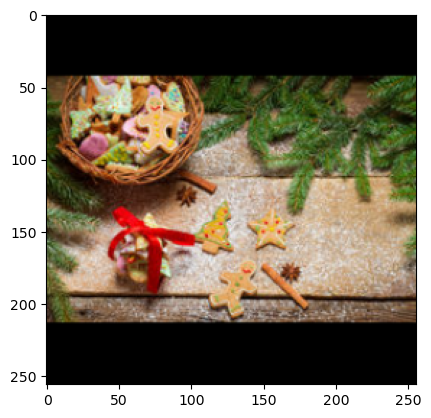

Example 2:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] what to put in a baby gift basket - there are many items you can put into a baby basket. clothes, blankets, bibs / burp cloths, diapers, bath products, items to feed with, music, toys - even snacks for mom and dad. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

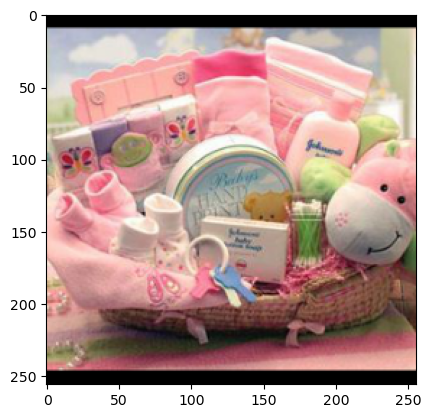

Example 3:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] the best rolled sugar cookies [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

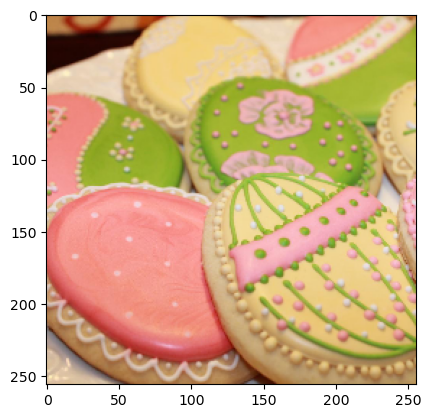

Example 4:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] новогодняя экскурсия по екатеринбургу на автомобиле : фото 2 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

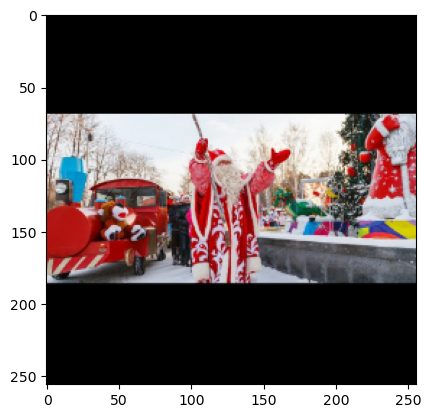

Example 5:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] yoke dress in small red and white check smocked with candy canes [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

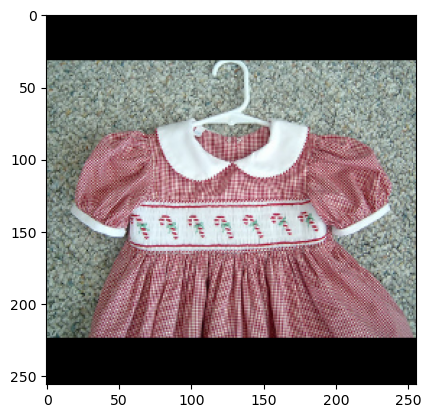

In [28]:
# load the dataset
dataset = load_dataset("laion/laion-art")

# split the dataset into train and test
dataset_split = dataset["train"].train_test_split(test_size=0.1, seed=0)
ds_train = dataset_split["train"].select(range(2000))
ds_test = dataset_split["test"].select(range(100))

# unit size
unit_size = (256, 256)

def pad_and_resize(image, target_size):
    # Calculate the aspect ratio of the target size
    target_aspect_ratio = target_size[0] / target_size[1]

    # Calculate the aspect ratio of the current image
    current_aspect_ratio = image.shape[2] / image.shape[1]

    # Determine the padding dimensions
    if current_aspect_ratio > target_aspect_ratio:
        # If the current image has a greater aspect ratio than the target,
        # we need to increase the height of the image (add padding to top and bottom)
        new_height = int(image.shape[2] / target_aspect_ratio)
        pad_top = (new_height - image.shape[1]) // 2
        pad_bottom = new_height - image.shape[1] - pad_top
        padding = (0, 0, pad_top, pad_bottom)  # padding for left, right, top, bottom
    else:
        # If the current image has a smaller aspect ratio than the target,
        # we need to increase the width of the image (add padding to left and right)
        new_width = int(image.shape[1] * target_aspect_ratio)
        pad_left = (new_width - image.shape[2]) // 2
        pad_right = new_width - image.shape[2] - pad_left
        padding = (pad_left, pad_right, 0, 0)  # padding for left, right, top, bottom

    # Add padding to the image
    image = F.pad(image, padding, "constant", 0)

    # Resize the image tensor to the target size
    image = F.interpolate(image.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)

    return image.squeeze(0)

def load_image(url):
    try:
        # load the iamge
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = torch.tensor(np.array(img))

        # convert to 3D float tensor
        if img.ndim == 2:
            img = img[:, :, None]
        if img.shape[2] == 1:
            img = img.repeat(1, 1, 3)
        img = img.permute(2, 0, 1).float()
        img = pad_and_resize(img, unit_size)

        return img
    except:
        return torch.zeros(3, unit_size[0], unit_size[1])

# preprocess the data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def preprocess_function(examples):
    # tokenize the text
    toks = tokenizer(examples["TEXT"], padding="max_length", truncation=True)

    # load the image
    toks["image"] = [load_image(url) for url in examples["URL"]]

    # filter out examples where image is empty tensor
    # toks = {k: [v[i] for i, img in enumerate(toks["image"]) if img.sum() > 0] for k, v in toks.items()}
    return toks


# DEBUG: show images
# visualize 5 examples from the train data
# for i in range(5):
#     print(f"Example {i+1}:")
#     print(ds_train[i]["TEXT"])
#     url = ds_train[i]["URL"]
#     # load the image
#     plt.imshow(img)
#     plt.show()
#     print()

# tokenize the data
ds_train = ds_train.map(preprocess_function, batched=True, batch_size=100, num_proc=8)
ds_test = ds_test.map(preprocess_function, batched=True, batch_size=100, num_proc=8)

# filter all empty images
ds_train = ds_train.filter(lambda x: torch.tensor(x["image"]).sum() > 0)
ds_test = ds_test.filter(lambda x: torch.tensor(x["image"]).sum() > 0)

# validate that folders exist
for ds in ["ds_train", "ds_test"]:
    os.makedirs(f"{CACHE_LOCATION}/{ds}", exist_ok=True)
# save the datasets to disk
ds_train.save_to_disk(f"{CACHE_LOCATION}/ds_train-2000")
ds_test.save_to_disk(f"{CACHE_LOCATION}/ds_test-100")

# visualize the images
for i in range(5):
    print(f"Example {i+1}:")
    print(ds_train[i].keys())
    toks = ds_train[i]["input_ids"]
    img = torch.tensor(ds_train[i]["image"])
    img = img.permute(1, 2, 0).byte()

    # print the tokens and image
    print(tokenizer.decode(toks))
    plt.imshow(img)
    plt.show()


Example 1:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] μικρο συνολο καλαθιων των μπισκοτων μελοψωματων για τα χριστουγεννα στοκ εικονα [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

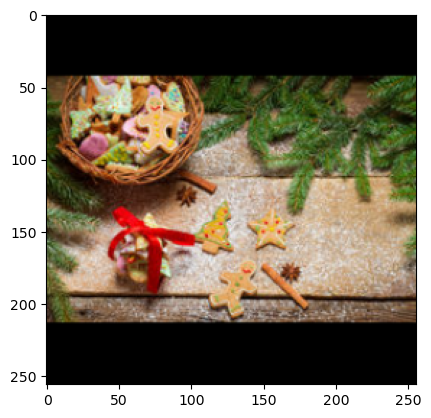

Example 2:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] what to put in a baby gift basket - there are many items you can put into a baby basket. clothes, blankets, bibs / burp cloths, diapers, bath products, items to feed with, music, toys - even snacks for mom and dad. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

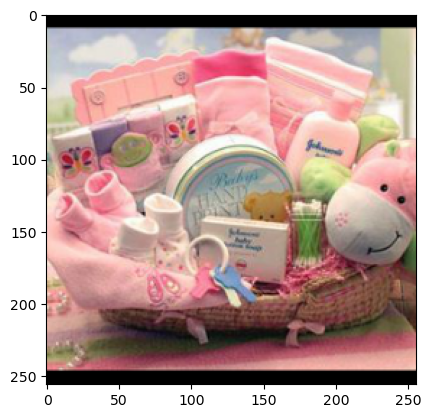

Example 3:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] the best rolled sugar cookies [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

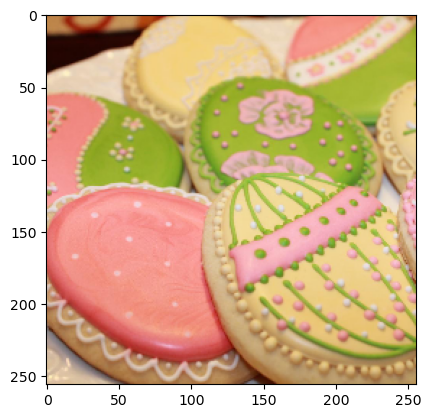

Example 4:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] новогодняя экскурсия по екатеринбургу на автомобиле : фото 2 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

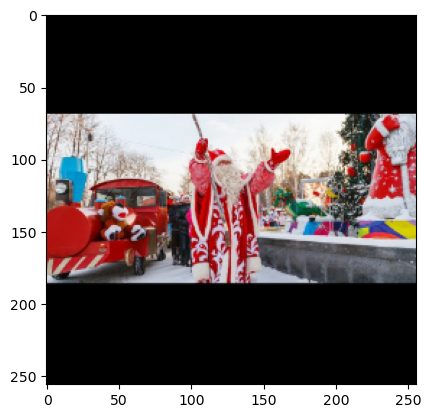

Example 5:
dict_keys(['URL', 'TEXT', 'WIDTH', 'HEIGHT', 'similarity', 'LANGUAGE', 'hash', 'pwatermark', 'punsafe', 'aesthetic', 'input_ids', 'token_type_ids', 'attention_mask', 'image'])
[CLS] yoke dress in small red and white check smocked with candy canes [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

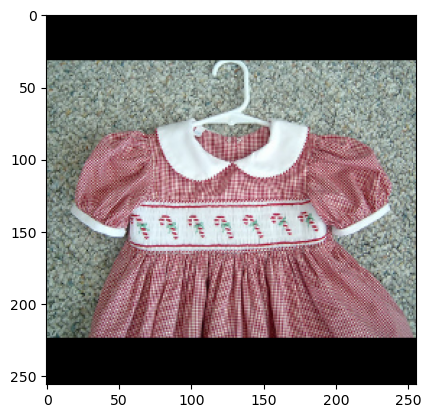

In [32]:
# load the datasets from disk
ds_train = load_from_disk(f"{CACHE_LOCATION}/ds_train-2000")
ds_test = load_from_disk(f"{CACHE_LOCATION}/ds_test-100")

# visualize the images
for i in range(5):
    print(f"Example {i+1}:")
    print(ds_train[i].keys())
    toks = ds_train[i]["input_ids"]
    img = torch.tensor(ds_train[i]["image"])
    img = img.permute(1, 2, 0).byte()

    # print the tokens and image
    print(tokenizer.decode(toks))
    plt.imshow(img)
    plt.show()

Take the utils data and load the dataset from that class:

Example 1:
[CLS] μικρο συνολο καλαθιων των μπισκοτων μελοψωματων για τα χριστουγεννα στοκ εικονα [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

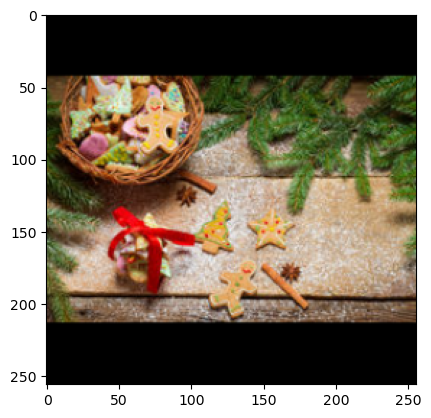

Example 2:
[CLS] what to put in a baby gift basket - there are many items you can put into a baby basket. clothes, blankets, bibs / burp cloths, diapers, bath products, items to feed with, music, toys - even snacks for mom and dad. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

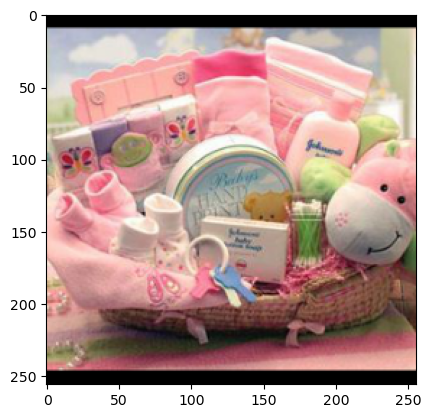

Example 3:
[CLS] the best rolled sugar cookies [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

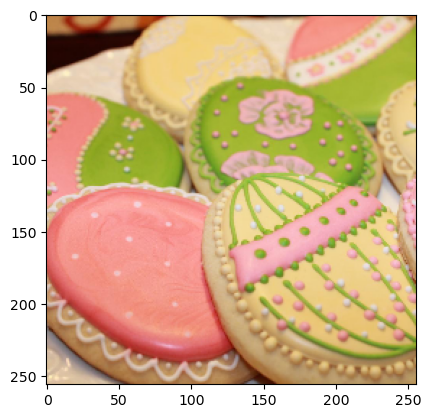

Example 4:
[CLS] новогодняя экскурсия по екатеринбургу на автомобиле : фото 2 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

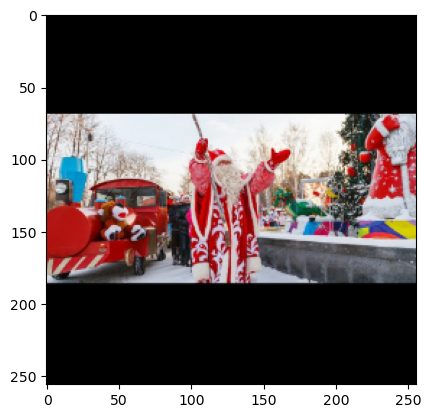

Example 5:
[CLS] yoke dress in small red and white check smocked with candy canes [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

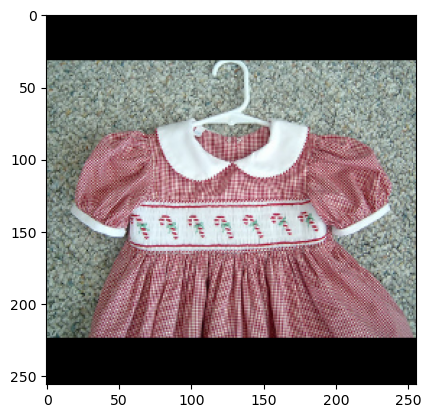

In [43]:
from dataset import DatasetLoader

# load the dataset
dsl = DatasetLoader()

# load the dataset and visualize
ds_train, ds_test = dsl.load()
# visualize(ds_train, dsl.tokenizer, 5)
dsl.visualize(ds_train, 5)

Next step is scaling the images and tokenizing the text, to have a full vector output of data.

## 2. Representation Learning

The next step is to build an Auto Encoder from scratch to learn a lower dimensional representation of the data.

First Load the dataset again and normalize the images:

Loading cached processed dataset at /Users/felixnext/Code/dump/.cache/hf_samples/laion-art/ds_train-2000/cache-046587262dec2115_*_of_00008.arrow
Loading cached processed dataset at /Users/felixnext/Code/dump/.cache/hf_samples/laion-art/ds_test-100/cache-c194ce8eee16cea8_*_of_00008.arrow


Example 1:
Stats: 0.0, 248.80859375
torch.Size([3, 64, 64])
[CLS] μικρο συνολο καλαθιων των μπισκοτων μελοψωματων για τα χριστουγεννα στοκ εικονα [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

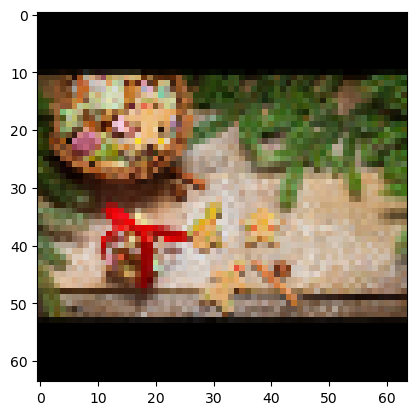

Example 2:
Stats: 0.0, 255.0
torch.Size([3, 64, 64])
[CLS] what to put in a baby gift basket - there are many items you can put into a baby basket. clothes, blankets, bibs / burp cloths, diapers, bath products, items to feed with, music, toys - even snacks for mom and dad. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

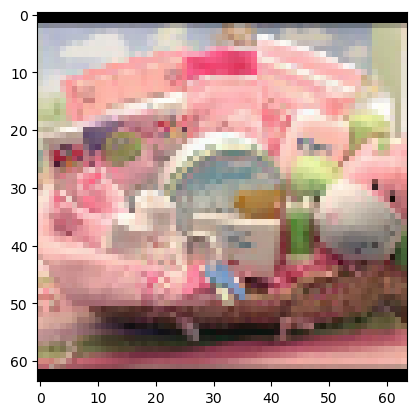

In [127]:
# preprocess the data to input size
train_img_size = (64, 64)
dims = 512
epochs = 30
batch_size = 256

def preprocess_function(examples):
    # reshape the image
    #print(examples["image"][0].shape)
    examples["image"] = [F.interpolate(torch.tensor(img).unsqueeze(0), size=train_img_size, mode='bilinear', align_corners=False).squeeze(0) / 255.0 for img in examples["image"]]
    # filter alpha channel
    examples["image"] = [img[:3] for img in examples["image"]]

    # normalize the image
    return examples

# preprocess the data
dsl = DatasetLoader()
ds_train, ds_test = dsl.load()
ds_train = ds_train.map(preprocess_function, batched=True, batch_size=100, num_proc=8)
ds_test = ds_test.map(preprocess_function, batched=True, batch_size=100, num_proc=8)

# visualize the images
for i in range(2):
    print(f"Example {i+1}:")
    toks = ds_train[i]["input_ids"]
    img = torch.tensor(ds_train[i]["image"]) * 255.0
    print(f"Stats: {img.min()}, {img.max()}")
    print(img.shape)
    img = img.permute(1, 2, 0).byte()

    # print the tokens and image
    print(dsl.tokenizer.decode(toks))
    plt.imshow(img)
    plt.show()

In [133]:
# define the dataset
class MiniAE(nn.Module):
    def __init__(self, input_size: tuple[int, int], dim: int = 256):
        super().__init__()

        # set dims
        self._emb_dim = dim
        self._in_dim = input_size

        # create layers
        # self._encoder = nn.Sequential(
        #     nn.Linear(input_size[0] * input_size[1] * 3, dim * 4),
        #     nn.ReLU(),
        #     nn.Linear(dim * 4, dim),
        #     nn.ReLU(),
        # )
        # self._decoder = nn.Sequential(
        #     nn.Linear(dim, dim * 4),
        #     nn.ReLU(),
        #     nn.Linear(dim * 4, input_size[0] * input_size[1] * 3),
        #     nn.Sigmoid(),
        # )

        # build cnn encoder
        self._encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # 64x64 - 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=7, stride=3, padding=1), # 4x4
            nn.Flatten(), # 1024
            nn.Linear(2048, dim), # 256
        )

        # build cnn decoder
        self._decoder = nn.Sequential(
            nn.Linear(dim, 2048), # 1024
            # convert into 3d tensor
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=7, stride=3, padding=1, output_padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # reshape the image (check if batched)
        # if x.ndim == 4:
        #     x = x.view(x.shape[0], -1)
        # else:
        #     x = x.view(1, -1)

        # encode the image
        x = self._encoder(x)

        # decode the image
        x = self._decoder(x)

        # reshape the image
        #x = x.view(-1, 3, self._in_dim[0], self._in_dim[1])

        return x
    
# create the auto-encoder
ae = MiniAE(train_img_size, dims)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
# select image and input_ids from the dataset and convert to tensor
ds_train.set_format(type='torch', columns=['image', 'input_ids'])
ds_test.set_format(type='torch', columns=['image', 'input_ids'])
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size * 2, shuffle=False)

# print number of parameters
print(f"Number of parameters: {sum(p.numel() for p in ae.parameters())}")


# start the training
for epoch in range(epochs):
    loss = 0
    count = 0
    # iterate through train data
    for data in train_loader:
        # load the data
        img = data["image"]
        output = ae(img)
        ls = criterion(output, img)

        # store the loss
        loss += ls.item()
        count += 1

        # check for updates
        if count % 100 == 0:
            print(f"Epoch: {epoch+1}, Step: {count}, Loss: {loss / count}")

        # Backward pass and optimize
        optimizer.zero_grad()
        ls.backward()
        optimizer.step()
    loss /= count
    
    # compute the test loss (with no gradients)
    with torch.no_grad():
        test_loss = 0
        test_count = 0
        for data in test_loader:
            # load the data
            img = data["image"]
            output = ae(img)
            ls = criterion(output, img)

            # store the loss
            test_loss += ls.item()
            test_count += 1

        # print the loss
        test_loss /= test_count
    
    print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, epochs, loss, test_loss))

Number of parameters: 2941443
Epoch [1/30], Loss: 0.1207, Test Loss: 0.1131
Epoch [2/30], Loss: 0.1057, Test Loss: 0.0915
Epoch [3/30], Loss: 0.0876, Test Loss: 0.0812
Epoch [4/30], Loss: 0.0766, Test Loss: 0.0717
Epoch [5/30], Loss: 0.0674, Test Loss: 0.0646
Epoch [6/30], Loss: 0.0627, Test Loss: 0.0616
Epoch [7/30], Loss: 0.0596, Test Loss: 0.0586
Epoch [8/30], Loss: 0.0567, Test Loss: 0.0557
Epoch [9/30], Loss: 0.0545, Test Loss: 0.0535
Epoch [10/30], Loss: 0.0528, Test Loss: 0.0514
Epoch [11/30], Loss: 0.0511, Test Loss: 0.0500
Epoch [12/30], Loss: 0.0498, Test Loss: 0.0491
Epoch [13/30], Loss: 0.0485, Test Loss: 0.0471
Epoch [14/30], Loss: 0.0473, Test Loss: 0.0459
Epoch [15/30], Loss: 0.0459, Test Loss: 0.0445
Epoch [16/30], Loss: 0.0447, Test Loss: 0.0435
Epoch [17/30], Loss: 0.0436, Test Loss: 0.0422
Epoch [18/30], Loss: 0.0426, Test Loss: 0.0413
Epoch [19/30], Loss: 0.0420, Test Loss: 0.0407
Epoch [20/30], Loss: 0.0415, Test Loss: 0.0394
Epoch [21/30], Loss: 0.0406, Test Loss:

Visualize Examples from the Test Dataset:

/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_67807/3219184153.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(data["image"])


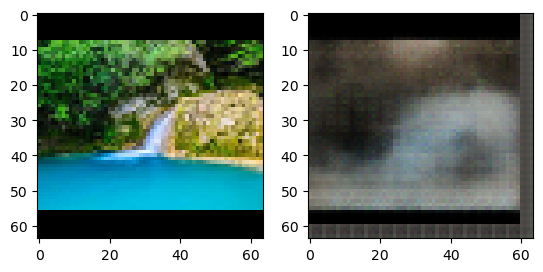

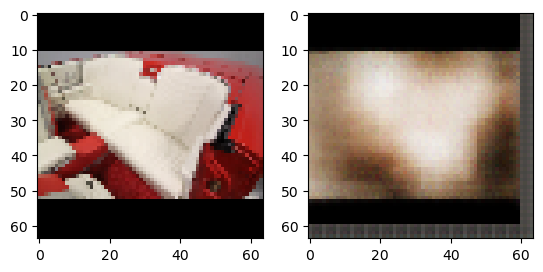

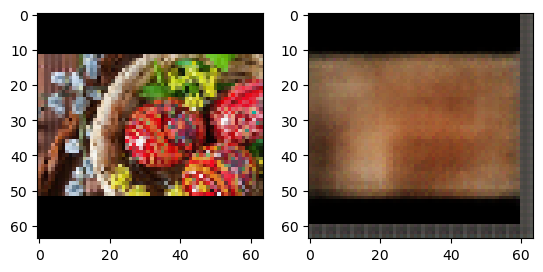

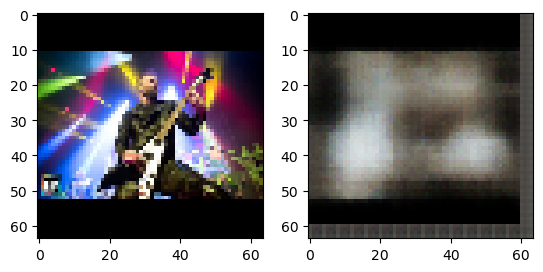

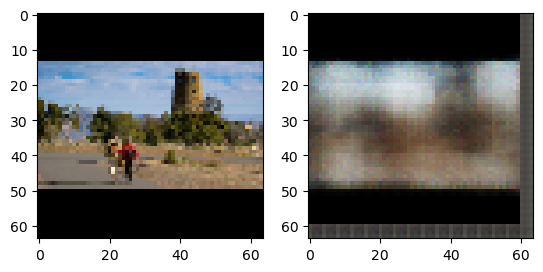

In [135]:
for i in range(5):
    # load the data
    data = ds_test[i]
    img = torch.tensor(data["image"])
    output = ae(img.unsqueeze(0))
    output = output.squeeze(0)
    output = output.permute(1, 2, 0).detach().numpy()

    # plot both images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img.permute(1, 2, 0).detach().numpy())
    ax2.imshow(output)
    plt.show()


ToDo:

- [ ] Visualize Embeddings
- [ ] Visualize Reconstruction (function)
- [ ] Debug the code (find bottlenecks where information gets losts)
- [ ] Train a VAE (colorize images)